In [21]:
%pip install scipy
%pip install matplotlib
%pip install wave
%pip install boto3
%pip install dbutils
%pip install numpy
%pip install pydub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [26]:
import boto3
import io
import os
from pydub import AudioSegment
import matplotlib.pyplot as plt

# Inicializar a sessão e o cliente S3
session = boto3.Session()
s3 = session.client('s3')

# Detalhes do S3
bucket_name = 'bucketuserterminator'
s3_key = 'bronze/joao_ogg.wav'
local_file_path = '/tmp/joao_ogg.wav'

response = s3.get_object(Bucket=bucket_name, Key=s3_key)
file_stream = response['Body']
file_content = file_stream.read()

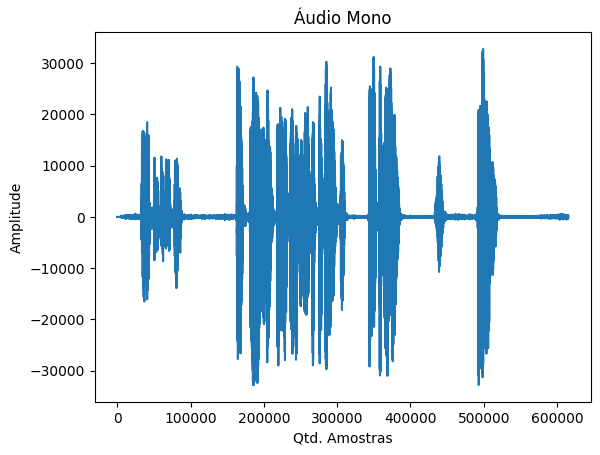

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import io
from scipy.io import wavfile as wav

# Usar scipy.io.wavfile para ler o arquivo de áudio
rate, data = wav.read('/tmp/joao_ogg.wav')

# Verificar se o áudio é estéreo (2 canais)
if len(data.shape) == 2:
    # Se for estéreo, converter para mono somando os dois canais e normalizando
    data = np.mean(data, axis=1)

# Plotar o áudio convertido (ou original se já for mono)
plt.plot(data)
plt.xlabel('Qtd. Amostras')
plt.ylabel('Amplitude')
plt.title('Áudio Mono')
plt.show()

Text(0, 0.5, 'Amplitute')

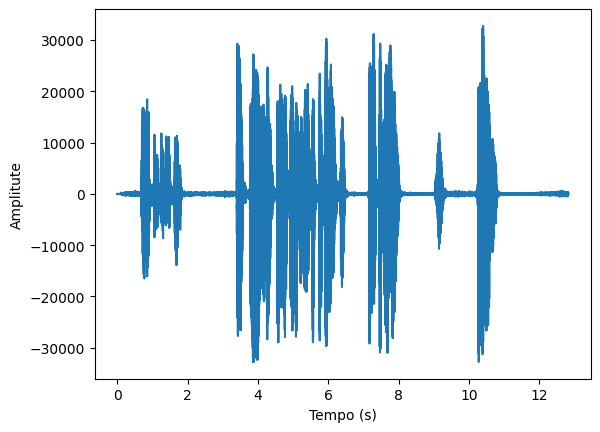

In [30]:
# encontrar o comprimento (total de amostras)
n = len(data)

# Frequencia de amostragem por sinal (quantas amostras por segundo)
fs = 48000 #48khz (audio) ou 44100 44.1khz (padrao spotify apple music) 
# https://emastered.com/pt/blog/sample-rate-for-audio#:~:text=A%20melhor%20taxa%20de%20amostragem,da%20sua%20onda%20sonora%20original.


T = 1/fs # tempo entre uma amostra e outra (inverso entre uma amostra e outra)

t = np.arange(0,n/fs,T) # (vetor de tempo) começa em 0seg, vai até o valor final do comprimento / frequencia de amostragem, e vai andando de T em T (valor calculado na variavel T)

plt.plot(t, data)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitute')

Text(0, 0.5, 'Amplitute')

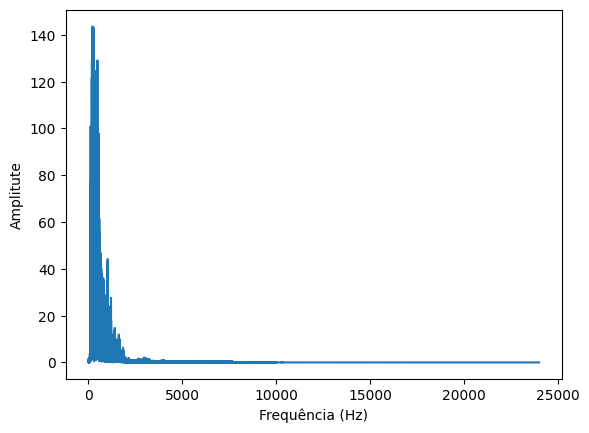

In [31]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# saindo de segundos e indo para hz
f = fftfreq(n,T)

# numero complexo (transformada)
transf = fft(data)

# módulo - para tirar os números complexos (módulo)
transf = np.abs(transf)

plt.plot(f[f > 0],transf[f > 0]*1/n) # mascara para pegar apenas os sinais com frequencias maiores que zeros e normalização o eixo vertical (dividir a transformada pelo tamanho do sinal)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitute')

In [39]:
ranges = np.arange(40, 301, 10)  # Intervalos de 10 em 10 Hz
fuzfactor = 1  # Fator de ajuste menor para mais precisão

# Inicialização dos highscores e points para os intervalos de interesse
highscores = [0] * len(ranges)
points = [0] * len(ranges)

# Processamento da transformada completa
for freq in range(40, 301):
    if transf[freq] > 0:
        mag = np.log(np.abs(transf[freq]) + 1)
        i = 0
        while i < len(ranges) and ranges[i] < freq:
            i += 1
        if i < len(ranges) and mag > highscores[i]:
            highscores[i] = mag
            points[i] = freq

# Cálculo da hashtag única com mais detalhes
h = 0
for i in range(len(points)):
    h += (points[i] - (points[i] % fuzfactor)) * (10 ** (len(points) - i - 1))

print(f"Hashtag: {h}")

# Extraindo os pontos individuais para leitura
h_copy = h
extracted_points = []

for i in range(len(points)):
    factor = 10 ** (len(points) - i - 1)
    point = (h_copy // factor) * fuzfactor
    extracted_points.append(point)
    h_copy %= factor

print(f"Frequencias: {extracted_points}")

Hashtag: 4516360545615176839611710201
Frequencias: [45, 1, 6, 3, 6, 0, 5, 4, 5, 6, 1, 5, 1, 7, 6, 8, 3, 9, 6, 1, 1, 7, 1, 0, 2, 0, 1]


In [41]:
import json

# Criação de um dicionário com a variável
joao_hashtag = {"hashtag": h}

# Conversão do dicionário para JSON
json_dados = json.dumps(joao_hashtag, indent=4)

bytes_dados = json_dados.encode('utf-8')
response = s3.put_object(Body=bytes_dados, Bucket='bucketuserterminator', Key='silver/joao_hashtag.json')